In [2]:
# Importierung von benötigten Bibliotheken 
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


tf.random.set_seed(7)

# Einlesen des Datensatzes von der CSV-Datei
df = pd.read_csv('C:/Users/han8h/Desktop/Ai/yahoo_stock.csv')

# Date Spalte als Datum festlegen
df['Date'] = pd.to_datetime(df["Date"])
# 'Date', 'Close', 'High', 'Low' und 'Open' werden für für den Datensatz ausgewählt
df = df.loc[: , ['Date', 'Close', 'High', 'Low', 'Open']]
# Anzeigen der ersten fünf Einträge
df.head()

,Date,Close,High,Low,Open
0,2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912
1,2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922
2,2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049
3,2015-11-26,2088.870117,2093.000000,2086.300049,2089.300049
4,2015-11-27,2090.110107,2093.290039,2084.129883,2088.820068


In [2]:
# Zeigen der Form der Daten
df.shape

(1825, 5)

In [3]:


# Zeitbezogene Merkmale
def create_date_features(df):
    df['month'] = df.Date.dt.month.astype("int8")  # Monat
    df['day_of_month'] = df.Date.dt.day.astype("int8")  # Tag des Monats
    df['day_of_year'] = df.Date.dt.dayofyear.astype("int16")  # Tag des Jahres
    df['week_of_month'] = (df.Date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")  # Woche des Monats
    df['week_of_year'] = (df.Date.dt.weekofyear).astype("int8")  # Woche des Jahres
    df['day_of_week'] = (df.Date.dt.dayofweek + 1).astype("int8")  # Wochentag
    df['year'] = df.Date.dt.year.astype("int32")  # Jahr
    df["is_wknd"] = (df.Date.dt.weekday // 4).astype("int8")  # Wochenende
    df["quarter"] = df.Date.dt.quarter.astype("int8")  # Quartal
    df['is_month_start'] = df.Date.dt.is_month_start.astype("int8")  # Monatsanfang
    df['is_month_end'] = df.Date.dt.is_month_end.astype("int8")  # Monatsende
    df['is_quarter_start'] = df.Date.dt.is_quarter_start.astype("int8")  # Quartalsanfang
    df['is_quarter_end'] = df.Date.dt.is_quarter_end.astype("int8")  # Quartalsende
    df['is_year_start'] = df.Date.dt.is_year_start.astype("int8")  # Jahresanfang
    df['is_year_end'] = df.Date.dt.is_year_end.astype("int8")  # Jahresende
    # 0: Winter - 1: Frühling - 2: Sommer - 3: Herbst
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)  # Jahreszeit bestimmen
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])  # Sommer
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")  # Herbst
    return df




In [4]:
# Anwenden der vorher definierten Funktion auf den Datensatz df
temp = create_date_features(df)
# Anzeigen der ersten fünf Einträge
temp.head()


F:\anaconda\envs\ai\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,...,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912,11,23,327,4,48,...,2015,0,4,0,0,0,0,0,0,3
1,2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922,11,24,328,4,48,...,2015,0,4,0,0,0,0,0,0,3
2,2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049,11,25,329,4,48,...,2015,0,4,0,0,0,0,0,0,3
3,2015-11-26,2088.870117,2093.000000,2086.300049,2089.300049,11,26,330,4,48,...,2015,0,4,0,0,0,0,0,0,3
4,2015-11-27,2090.110107,2093.290039,2084.129883,2088.820068,11,27,331,4,48,...,2015,1,4,0,0,0,0,0,0,3


In [5]:
# Importieren von weiteren wichtigen Bibliotheken

import seaborn as sns
import math

from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [6]:
# Fourier-Transformation und deterministischer Prozess, um saisonale und trendbezogene Zeitfeatures zu generieren und diese mit den Originaldaten zu kombinieren, um die Modellierung zeitabhängiger Muster zu verbessern.
fourier = CalendarFourier(freq = 'Y', order = 3)  # Fourier-Transformation für saisonale Komponenten
dp = DeterministicProcess(index = temp.Date,
                          order = 1,  # Trendkomponente
                          seasonal = False,  # Keine Saisonalität
                          constant = False,  # Keine Konstante
                          additional_terms = [fourier],  # Hinzufügen von Fourier-Terms 
                          drop = True)  # Dropt Originalterme
time = dp.in_sample()  # Generiert deterministische Zeitfeatures (regelmäßige Muster in Zeitreihendaten)

time = time.reset_index()  # Index zurücksetzen

print(time.shape)  # Ausgabe der Dimensionen von 'time'

temp_join = pd.merge(temp, time, how='inner', left_on='Date', right_on='Date')  # Zusammenführen von Original- und Zeitfeatures
print(temp_join.shape)  # Ausgabe der Dimensionen von 'temp_join'

temp_join.head()  # Anzeigen der ersten Zeilen von 'temp_join'


(1825, 8)
(1825, 28)


,Date,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,...,is_year_start,is_year_end,season,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
0,2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912,11,23,327,4,48,...,0,0,3,1.0,-0.622047,0.782980,-0.974100,0.226116,-0.903356,-0.428892
1,2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922,11,24,328,4,48,...,0,0,3,2.0,-0.608477,0.793572,-0.965740,0.259512,-0.924291,-0.381689
2,2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049,11,25,329,4,48,...,0,0,3,3.0,-0.594727,0.803928,-0.956235,0.292600,-0.942761,-0.333469
3,2015-11-26,2088.870117,2093.000000,2086.300049,2089.300049,11,26,330,4,48,...,0,0,3,4.0,-0.580800,0.814046,-0.945596,0.325342,-0.958718,-0.284359
4,2015-11-27,2090.110107,2093.290039,2084.129883,2088.820068,11,27,331,4,48,...,0,0,3,5.0,-0.566702,0.823923,-0.933837,0.357698,-0.972118,-0.234491


In [7]:
# Importieren von weiteren wichtigen Bibliotheken

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [8]:
temp_join = temp_join.set_index(['Date'])  # Setzt 'Date' als Index
temp_join.head(3)  # Zeigt die ersten 3 Zeilen von 'temp_join' an

,Close,High,Low,Open,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,...,is_year_start,is_year_end,season,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-23,2086.590088,2095.610107,2081.389893,2089.409912,11,23,327,4,48,1,...,0,0,3,1.0,-0.622047,0.782980,-0.974100,0.226116,-0.903356,-0.428892
2015-11-24,2089.139893,2094.120117,2070.290039,2084.419922,11,24,328,4,48,2,...,0,0,3,2.0,-0.608477,0.793572,-0.965740,0.259512,-0.924291,-0.381689
2015-11-25,2088.870117,2093.000000,2086.300049,2089.300049,11,25,329,4,48,3,...,0,0,3,3.0,-0.594727,0.803928,-0.956235,0.292600,-0.942761,-0.333469


In [9]:
# Festlegung der größe des Train- und Testdatensatzes

train_size = int(0.85 * len(temp_join))
test_size = len(temp_join) - train_size

In [10]:
# Aufteilung in Train- und Testdatensatz
train_set, test_set = temp_join.iloc[:-test_size, :], temp_join.iloc[-test_size: , :]
train_set.shape, test_set.shape

((1551, 27), (274, 27))

In [11]:
# Skalieren der Daten mittels MinMaxScaler auf Werte zwischen -1 und 0

scaler = MinMaxScaler(feature_range=(-1, 0))

train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

train_scaled.shape, test_scaled.shape

((1551, 27), (274, 27))

In [12]:
scaled_data = np.append(train_scaled, test_scaled, axis=0)  # Kombiniert skalierte Train- und Testdaten
scaled_data.shape  # Gibt die Form von 'scaled_data' aus

(1825, 27)

In [13]:
train_size = train_set.shape[0]  # Anzahl der Trainingsdaten
test_size = test_set.shape[0]  # Anzahl der Testdaten

# Festlegung der Anzahl der Tage für die Vorhersage
look_back = 20
# Aufteilung in Train- und Testset
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)  # Erstellen des Trainingsdatensatzes
x_test, y_test = create_dataset(test, look_back)  # Erstellen des Testdatensatzes

# Umformung der Eingabe in [Samples, Zeitschritte, Features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))  # Umformung der Trainingsdaten
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))  # Umformung der Testdaten

print(len(x_train), len(x_test))  # Ausgabe der Länge der Trainings- und Testdaten


1511 274


In [14]:
train.shape

(1531, 27)

In [15]:
tf.random.set_seed(123)  # Setzt den Zufalls-Seed für Konsistenz und Vergleichbarkeit der Ergebnisse


In [16]:
# Aufbau des LSTM-Modells
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))  # Erste LSTM-Schicht mit 256 Neuronen
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))  # Leaky ReLU Aktivierungsfunktion
model.add(LSTM(128, return_sequences=True))  # Zweite LSTM-Schicht mit 128 Neuronen
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))  # Leaky ReLU Aktivierungsfunktion
model.add(tf.keras.layers.Dropout(0.20))  # Dropout-Schicht mit 20% Rate
model.add(LSTM(64, return_sequences=False))  # Dritte LSTM-Schicht mit 64 Neuronen
model.add(tf.keras.layers.Dropout(0.20))  # Dropout-Schicht mit 20% Rate
model.add(Dense(25))  # Dense-Schicht mit 25 Neuronen
model.add(Dense(1))  # Ausgabeschicht mit 1 Neuron

model.summary()  # Zusammenfassung des Modells


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            283648    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 128)            0         
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [17]:
# Earlystopping, um overfitting zu vermeiden
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

# Kompilierung des Modells
model.compile(optimizer=tf.optimizers.Adamax(), 
              loss=tf.losses.MeanAbsolutePercentageError(), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [18]:
# Training des LSTM-Netzwerkes
model.fit(x_train, y_train, batch_size=1, epochs=100, validation_data=(x_test, y_test),
         callbacks=[earlystopping])

Epoch 1/100
1511/1511 [==============================] - 56s 4ms/step - loss: 13.3541 - root_mean_squared_error: 0.0969 - val_loss: 82.3998 - val_root_mean_squared_error: 0.0730
Epoch 2/100
1511/1511 [==============================] - 4s 3ms/step - loss: 9.7114 - root_mean_squared_error: 0.0636 - val_loss: 102.9769 - val_root_mean_squared_error: 0.0601
Epoch 3/100
1511/1511 [==============================] - 4s 3ms/step - loss: 8.5992 - root_mean_squared_error: 0.0600 - val_loss: 74.5765 - val_root_mean_squared_error: 0.0511
Epoch 4/100
1511/1511 [==============================] - 4s 3ms/step - loss: 7.6655 - root_mean_squared_error: 0.0519 - val_loss: 78.5958 - val_root_mean_squared_error: 0.0465
Epoch 5/100
1511/1511 [==============================] - 4s 3ms/step - loss: 7.1496 - root_mean_squared_error: 0.0489 - val_loss: 123.8407 - val_root_mean_squared_error: 0.0467


In [19]:
# Vorhersagen mit dem Modell
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

9/9 [==============================] - 0s 2ms/step


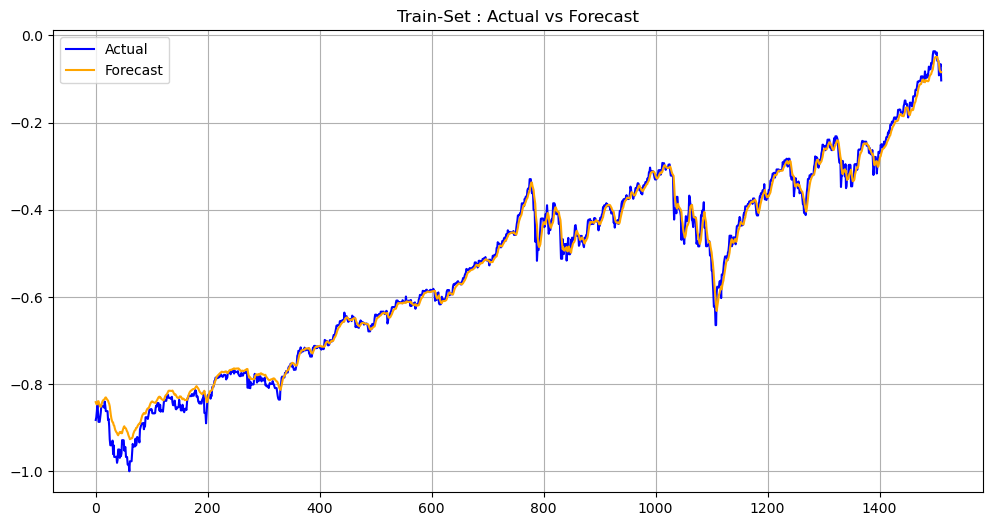

In [21]:
# Plotten der Performance am Train-Set

import matplotlib.pyplot as plt

plt.figure(figsize = (12 , 6))
plt.plot(y_train , 'b' , label = 'Actual')
plt.plot(np.array(train_predict).squeeze() , 'orange' , label = 'Forecast')
plt.grid()
plt.legend()
plt.title("Train-Set : Actual vs Forecast")
plt.show()

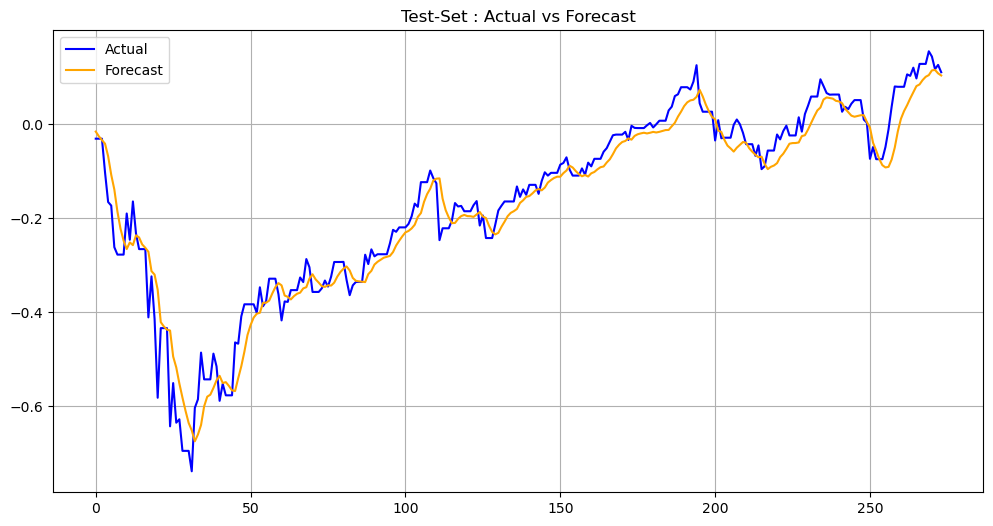

In [22]:
# Plotten der Performance am Test-Set

plt.figure(figsize = (12 , 6))
plt.plot(y_test , 'b' , label = 'Actual')
plt.plot(np.array(test_predict).squeeze() , 'orange' , label = 'Forecast')
plt.grid()
plt.legend()
plt.title("Test-Set : Actual vs Forecast")
plt.show()

In [23]:
# Ausgabe des RMSE (Root Mean Square Error) für Test- und Trainingsdaten

print(f'The RMSE for test set is {round(mean_squared_error(y_test, np.array(test_predict).squeeze(), squared=False), 2)}')
print('\n')
print('\n')
print(f'The RMSE for train set is {round(mean_squared_error(y_train, np.array(train_predict).squeeze(), squared=False), 2)}')

The RMSE for test set is 0.05




The RMSE for train set is 0.02
